In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import pandas as pd
import numpy as np
from forecast.metrics import CRPS_ensemble, energy_score
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt

In [3]:
# open csv file for scenarios
scens = pd.read_csv('debug_logs/scenarios_recurrent_quant_s10_p1_24h.csv')
scens

,time_step,scenario,building,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h,+24h
0,0,0,0,4.680223,-0.873067,-0.358116,-2.200851,-2.405120,-2.509296,-2.536108,...,0.295618,0.845874,-0.763193,-0.912645,-0.928508,-1.908341,0.936617,1.395755,3.324676,-1.705600
1,0,0,1,-0.046106,-0.879706,-1.799014,-1.826518,-1.830499,-1.847256,-2.028202,...,-1.981275,-1.603651,-1.877480,-0.941312,-0.510731,0.480975,1.754592,2.041151,2.754921,-1.355491
2,0,0,2,-0.515360,-0.493457,-1.511261,-2.154829,-2.382758,-2.448164,-2.503421,...,-2.383084,-2.542592,-0.517371,-0.963526,0.472468,0.044315,-0.517929,-0.616692,-1.088153,-0.898864
3,0,0,3,0.916038,1.760046,-1.659371,-2.165884,-2.246393,-2.251395,-2.364278,...,-2.550839,-2.291432,-2.026714,0.525965,0.974101,-2.007347,-2.065438,-2.010015,-2.134335,-2.276454
4,0,0,4,-0.126008,-1.580785,-1.050002,-2.031067,-2.221354,-2.257538,-2.442041,...,0.456228,-0.413211,0.595383,-0.272736,0.039983,-1.768603,-1.793817,-0.795831,0.757169,0.196293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437995,8759,9,0,1.545409,1.242332,1.075266,0.684516,0.642633,0.745352,1.146794,...,-1.618277,-0.486707,0.625177,0.872990,1.252561,1.586253,5.446410,4.218322,2.915977,1.441892
437996,8759,9,1,2.392416,1.454427,0.721839,0.744348,1.272803,0.553367,0.659005,...,-0.721404,0.617393,-0.284813,0.027237,0.808336,1.681687,1.937622,4.046105,0.664918,2.251730
437997,8759,9,2,-0.137613,-0.151824,0.663919,0.361949,1.005214,2.797794,1.862877,...,-1.066010,0.192756,0.503283,1.154499,2.232680,-0.208902,-0.172664,-0.600817,-0.046732,-0.164040
437998,8759,9,3,1.029267,0.954064,2.246369,0.551836,0.609102,0.651827,0.714897,...,-0.333379,-0.578450,0.096919,0.547617,1.911729,1.324221,1.084893,1.483411,0.582748,1.229442


In [4]:
reals = pd.read_csv('debug_logs/real_power_recurrent_quant_s10_p1_24h.csv')
reals

,time_step,building_0,building_1,building_2,building_3,building_4
0,-1,2.275800,2.188750,1.009623e-07,2.819150,0.771433
1,0,0.851167,1.370667,1.018524e-07,1.928167,0.515883
2,1,0.834600,1.101250,1.008352e-07,0.475817,0.503050
3,2,0.838167,0.543217,1.007080e-07,0.458233,0.535950
4,3,1.478433,0.542833,1.015981e-07,0.446017,0.512617
...,...,...,...,...,...,...
8755,8754,1.314867,1.502683,1.417733e+00,1.591967,2.713900
8756,8755,2.566167,0.803133,1.075767e+00,0.389433,0.935833
8757,8756,3.151700,2.194633,1.162883e+00,1.186483,2.155017
8758,8757,3.021500,1.456333,1.107300e+00,3.155883,2.316400


In [5]:
def crps(y_true, y_pred):
    """
    Computes the Continuous Ranked Probability Score (CRPS).

    Args:
        y_true (array-like): True values of the target variable, of shape (n_samples,)
        y_pred (array-like): Predicted values of the target variable, of shape (n_samples, n_forecasts)

    Returns:
        float: CRPS score.
    """
    n_samples = y_true.shape[0]
    n_forecasts = y_pred.shape[1]

    # Compute the first term of the CRPS formula
    crps_term1 = 0
    for t in range(n_samples):
        for i in range(n_forecasts):
            crps_term1 += abs(y_pred[t, i] - y_true[t])

    crps_term1 /= n_samples * n_forecasts

    # Compute the second term of the CRPS formula
    crps_term2 = 0
    for t in range(n_samples):
        for i in range(n_forecasts):
            for j in range(n_forecasts):
                crps_term2 += abs(y_pred[t, i] - y_pred[t, j])

    crps_term2 /= 2 * n_samples * n_forecasts ** 2

    # Compute the CRPS score
    crps_score = crps_term1 - crps_term2

    return crps_term1, crps_term2, crps_score

In [6]:
# calculate CRPS for each horizon and for each building and average over buildings
crps_scores = []
abs_scores = []
spread_scores = []
for i in range(1, 25):
    crps_scores_B = []
    abs_scores_B = []
    spread_scores_B = []
    for build in range(5):
        # obs_input and scens_input need to be sliced
        obs_input =  reals.loc[1:, ['building_' + str(build)]]
        scens_input = scens.loc[scens['building'] == build, ['scenario','+' + str(i) + 'h', 'time_step']]
        # pivot by scenario
        scens_input = scens_input.pivot(index='time_step',columns='scenario',  values='+' + str(i) + 'h')
        # convert to numpy array
        obs_input = obs_input.to_numpy()
        scens_input = scens_input.to_numpy()
        # calculate CRPS
        abs_diff, spread, score_B = crps(obs_input, scens_input)
        abs_scores_B.append(abs_diff)
        spread_scores_B.append(spread)
        crps_scores_B.append(score_B)
        print('CRPS score for building ' + str(build) + ' and horizon ' + str(i) + ' is ' + str(np.mean(crps_scores_B)))
    abs_scores.append(np.mean(abs_scores_B))
    spread_scores.append(np.mean(spread_scores_B))
    crps_scores.append(np.mean(crps_scores_B))


CRPS score for building 0 and horizon 1 is 0.3906515912192832
CRPS score for building 1 and horizon 1 is 0.3578455525443829
CRPS score for building 2 and horizon 1 is 0.3271497536742172
CRPS score for building 3 and horizon 1 is 0.3204551141148281
CRPS score for building 4 and horizon 1 is 0.3071881220511588
CRPS score for building 0 and horizon 2 is 0.5018846555144285
CRPS score for building 1 and horizon 2 is 0.45142587939231715
CRPS score for building 2 and horizon 2 is 0.41370762560698043
CRPS score for building 3 and horizon 2 is 0.4027625791454679
CRPS score for building 4 and horizon 2 is 0.3837324419689871
CRPS score for building 0 and horizon 3 is 0.6750837719892289
CRPS score for building 1 and horizon 3 is 0.5979173346394443
CRPS score for building 2 and horizon 3 is 0.5477516209839798
CRPS score for building 3 and horizon 3 is 0.5269010550821995
CRPS score for building 4 and horizon 3 is 0.5044904274736637
CRPS score for building 0 and horizon 4 is 0.8532209045249409
CRPS s

In [7]:
scens_pv = pd.read_csv('debug_logs/scenarios_point_and_variance_9000.csv')
scens_pv

,time_step,scenario,building,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h,+24h
0,0,0,0,1.174578,-0.978735,-0.930768,-1.154253,-0.914358,-0.581429,-0.602405,...,-1.036833,-1.166210,-0.159654,0.223371,-0.001311,0.075816,-0.280135,-1.373695,-1.000311,-0.939288
1,0,0,1,0.492962,-0.590275,-1.182318,-1.079209,-0.403129,-0.622702,-0.706671,...,-0.847446,-0.504486,-0.040699,-0.101848,-0.608349,-0.323820,-1.165168,-0.966422,-0.506016,-1.329590
2,0,0,2,-1.032145,-1.209802,-1.669238,-1.562547,-0.964545,-1.396137,-1.288957,...,-1.789294,-1.565947,-0.750864,-0.930754,-0.720852,-0.844530,-1.769777,-1.746396,-1.578181,-1.244607
3,0,0,3,1.073633,-0.872798,-1.629407,-1.906051,-1.612159,-1.540039,-1.228372,...,-0.991402,-1.187047,-1.010294,-0.641333,-1.554884,-0.610182,-0.635115,-1.451325,-0.919165,-1.090702
4,0,0,4,0.035512,-1.457885,-1.599486,-1.908076,-0.569714,-1.046940,-1.138085,...,-0.779457,-1.206630,-1.419744,-0.892312,-0.805790,-0.652330,-0.650801,-1.284845,-1.265259,-0.941883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437995,8759,9,0,2.057834,1.177753,0.348245,0.426647,0.849198,0.598197,0.375792,...,0.501012,0.786320,0.743811,1.833070,1.344823,1.684536,2.982464,2.871887,2.491966,2.467003
437996,8759,9,1,2.257851,0.669517,0.592456,0.641260,1.712513,0.554308,0.550684,...,0.557170,0.945650,-0.786990,-0.213683,-0.208239,1.908240,0.578932,1.816353,2.067238,1.905874
437997,8759,9,2,0.222746,-0.165178,0.012980,0.509997,0.580239,0.758037,-0.611246,...,-0.973811,-0.591283,-0.270580,-0.646775,0.513639,0.678016,0.973265,0.843901,0.116747,-0.894697
437998,8759,9,3,1.967523,0.985586,1.639501,1.025583,0.967045,0.950992,0.160888,...,0.105452,0.786714,0.527296,0.385375,1.137587,1.510073,0.724431,0.655580,0.775716,1.351027


In [8]:
# calculate CRPS for each horizon and for each building and average over buildings
crps_scores_pv = []
abs_scores_pv = []
spread_scores_pv = []
for i in range(1, 25):
    crps_scores_B = []
    abs_scores_B = []
    spread_scores_B = []
    for build in range(5):
        # obs_input and scens_input need to be sliced
        obs_input =  reals.loc[1:, ['building_' + str(build)]]
        scens_input = scens_pv.loc[scens_pv['building'] == build, ['scenario','+' + str(i) + 'h', 'time_step']]
        # pivot by scenario
        scens_input = scens_input.pivot(index='time_step',columns='scenario',  values='+' + str(i) + 'h')
        # convert to numpy array
        obs_input = obs_input.to_numpy()
        scens_input = scens_input.to_numpy()
        # calculate CRPS
        abs_diff, spread, score_B = crps(obs_input, scens_input)
        abs_scores_B.append(abs_diff)
        spread_scores_B.append(spread)
        crps_scores_B.append(score_B)
        print('CRPS score for building ' + str(build) + ' and horizon ' + str(i) + ' is ' + str(np.mean(crps_scores_B)))
    abs_scores_pv.append(np.mean(abs_scores_B))
    spread_scores_pv.append(np.mean(spread_scores_B))
    crps_scores_pv.append(np.mean(crps_scores_B))


CRPS score for building 0 and horizon 1 is 0.42892874385162616
CRPS score for building 1 and horizon 1 is 0.3899545387483486
CRPS score for building 2 and horizon 1 is 0.3535294246734315
CRPS score for building 3 and horizon 1 is 0.3481813365099687
CRPS score for building 4 and horizon 1 is 0.33595012913966976
CRPS score for building 0 and horizon 2 is 0.7190433493636726
CRPS score for building 1 and horizon 2 is 0.633760811264164
CRPS score for building 2 and horizon 2 is 0.5740595829935694
CRPS score for building 3 and horizon 2 is 0.5568714286502982
CRPS score for building 4 and horizon 2 is 0.5314727846168151
CRPS score for building 0 and horizon 3 is 0.9013502835032323
CRPS score for building 1 and horizon 3 is 0.7830542582721163
CRPS score for building 2 and horizon 3 is 0.708006240273602
CRPS score for building 3 and horizon 3 is 0.6777862306702832
CRPS score for building 4 and horizon 3 is 0.6510018483353556
CRPS score for building 0 and horizon 4 is 1.0678521833287549
CRPS sco

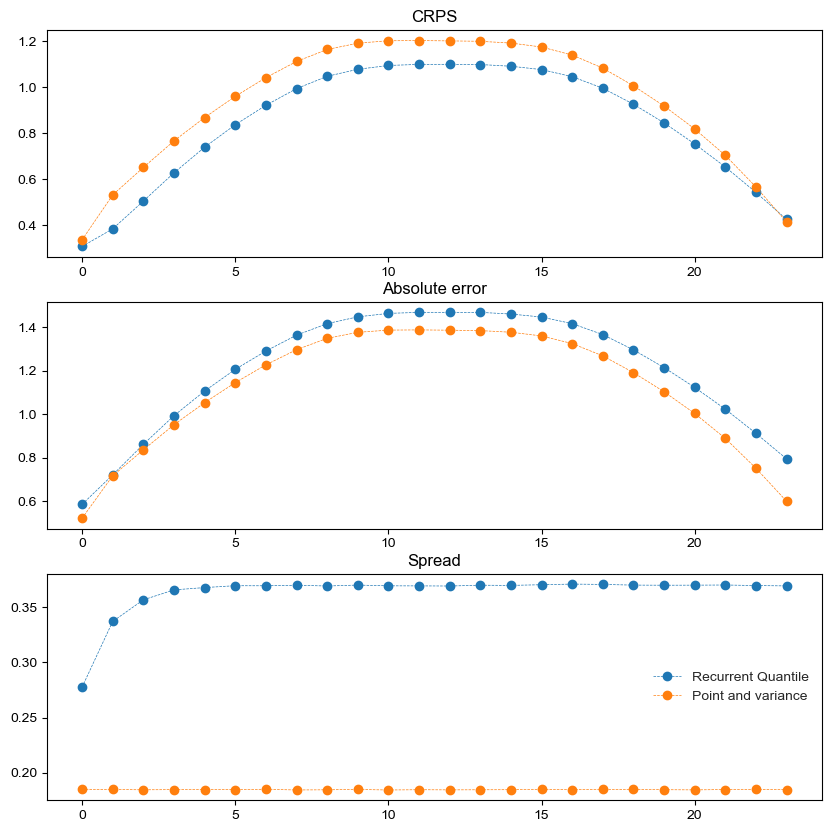

In [9]:
# make a plot with 3 subplots for each metric
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(crps_scores, marker='o', linestyle='--', linewidth=0.5)
axs[0].plot(crps_scores_pv, marker='o', linestyle='--', linewidth=0.5)
axs[0].set_title('CRPS')
axs[1].plot(abs_scores, marker='o', linestyle='--', linewidth=0.5)
axs[1].plot(abs_scores_pv, marker='o', linestyle='--', linewidth=0.5)
axs[1].set_title('Absolute error')
axs[2].plot(spread_scores, marker='o', linestyle='--', linewidth=0.5)
axs[2].plot(spread_scores_pv, marker='o', linestyle='--', linewidth=0.5)
axs[2].set_title('Spread')
# style
plt.style.use('seaborn')
# legend
plt.legend(['Recurrent Quantile', 'Point and variance'])
plt.show()

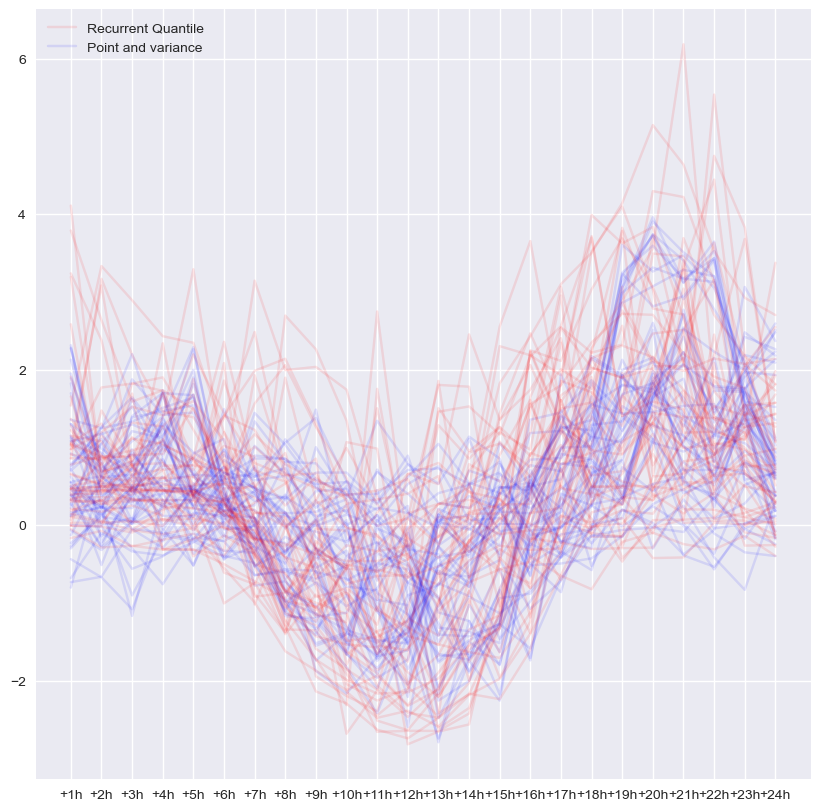

In [18]:
time_step = 345
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scens_pv.loc[scens_pv['time_step'] == 25].iloc[:, 3:].T, color='blue', alpha=0.1, label='Point and variance')
ax.plot(scens.loc[scens['time_step'] == 25].iloc[:, 3:].T, color='red', alpha=0.1, label='Recurrent Quantile')
# legend all blues lines are from point and variance and all red lines are from recurrent quantile
# Create a legend with unique labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles_dict = {label: [] for label in unique_labels}
for handle, label in zip(handles, labels):
    handles_dict[label].append(handle)
unique_handles = [handles_dict[label][0] for label in unique_labels]
ax.legend(unique_handles, unique_labels)
plt.show()